# Compute Isothermal Spectra

We need to compute synthetic spectra and continuum for our full bandpass as a function of temperature 

In [1]:
import sys

import numpy as np
import astropy.units as u
import hissw
import matplotlib.pyplot as plt

sys.path.append('../../scripts/')
from response import Channel, SpectrogramChannel

In [2]:
chan = SpectrogramChannel(0, '../data/MOXSI_effarea.genx')

In [3]:
ssw = hissw.Environment(ssw_packages=['chianti'])

In [4]:
script = '''
ioneq_name = '{{ [ ssw_home, 'packages/chianti/dbase/ioneq', ioneq_file ] | join('/') }}'
abund_name = '{{ [ ssw_home, 'packages/chianti/dbase/abundance', abundance_file ] | join('/') }}'
wavelength = {{ wavelength | to_unit('Angstrom') | list }}
wave_min = wavelength[0]
wave_max = wavelength[-1]
log_temperature = {{ temperature | to_unit('K') | log10 }}
density = {{ density | to_unit('cm-3') }}

;generate transition structure for selected wavelength and temperature range
ch_synthetic, wave_min, wave_max, output=transitions,$
              ioneq_name=ioneq_name,$
              logt_isothermal=log_temperature,$
              density=density[0]
              
;compute the spectra as a function of lambda and T
make_chianti_spec, transitions, wavelength, spectrum,$
                   abund_name=abund_name,$
                   /continuum,/lookup,/photons
'''

In [5]:
wavelength = chan.wavelength
temperature = 10**np.arange(5.5, 7.6, 0.1)*u.K
density = 1e15 * u.Unit('K cm-3') / temperature
ioneq_file = 'chianti.ioneq'
abundance_file = 'sun_coronal_1992_feldman.abund'

In [6]:
def get_isothermal_spectra(T, n):
    input_args = {
        'wavelength': wavelength,
        'temperature': T,
        'density': n,
        'ioneq_file': ioneq_file,
        'abundance_file': abundance_file,
    }
    output = ssw.run(script, args=input_args, save_vars=['spectrum'])
    spectrum = output['spectrum']['spectrum'][0]
    u.add_enabled_units([
        u.def_unit('photons', represents=u.photon),
        u.def_unit('Angstroms', represents=u.Angstrom)
    ])
    spectrum_unit = u.Unit(output['spectrum']['units'][0][1].decode('utf-8'))
    spectrum = u.Quantity(spectrum, spectrum_unit)
    # Originally, the spectrum was computed assuming unit EM.
    # Divide through to get the units right
    unit_em = 1 * u.Unit('cm-5')
    spectrum = spectrum / unit_em
    return spectrum

In [7]:
all_spectra = []
for t,n in zip(temperature, density):
    spec = get_isothermal_spectra(t,n)
    all_spectra.append(spec)
all_spectra = u.Quantity(all_spectra)

IDL 8.8.1 (linux x86_64 m64).
(c) 2021, Harris Geospatial Solutions, Inc.
% Error initializing graphics device GL.

Licensed for use by: NASA - Goddard Space Flight Center - MAIN
License: MNT-5527480
A new version is available: IDL 8.8.2
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: USE_CHIANTI.
% Compiled module: DIR_EXIST.
% DEVICELIB: Added system variable !BCOLOR
% DEVICELIB: Added system variable !ASPECT
% Compiled module: HISSW_PROCEDURE.
% Compiled module: CH_SYNTHETIC.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: DATATYPE.
% Compiled module: READ_IONEQ.
% Compiled module: READ_MASTERLIST.
% Compiled module: CONVERTNAME.
% Compiled module: STR_SEP.
% Compiled module: ION2SPECTROSCOPIC.
% Compiled module: ZION2FILENAME.
% Compiled module: SPLINE.
% Compiled module: CH_SETUP_ION.
% Compiled module: ION2FILENAME.
% Compiled module: READ_WGFA_STR.
% Compiled module: READ_ELVLC.
% Compiled module: ZION2SPECTROSCOPIC.
% Compiled module:

In [10]:
all_spectra.unit

Unit("cm3 photons / (Angstroms s sr)")

Figure out some way to serialize this to a file, maybe HDF5.
Put this all in a script, only run it when necessary

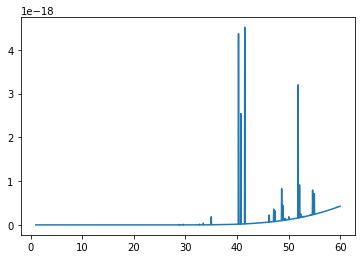

In [32]:
plt.plot(output['spectrum']['lambda'][0],output['spectrum']['spectrum'][0])

In [40]:
foo = output['transitions'][0]['lines'][0]

In [44]:
output['transitions'][0].dtype

dtype((numpy.record, [(('lines', 'LINES'), 'O'), (('ioneq_logt', 'IONEQ_LOGT'), 'O'), (('ioneq_name', 'IONEQ_NAME'), 'O'), (('ioneq_ref', 'IONEQ_REF'), 'O'), (('wvl_limits', 'WVL_LIMITS'), 'O'), (('model_file', 'MODEL_FILE'), 'O'), (('model_name', 'MODEL_NAME'), 'O'), (('model_ne', 'MODEL_NE'), 'O'), (('model_pe', 'MODEL_PE'), 'O'), (('model_te', 'MODEL_TE'), 'O'), (('wvl_units', 'WVL_UNITS'), 'O'), (('int_units', 'INT_UNITS'), 'O'), (('add_protons', 'ADD_PROTONS'), '>i2'), (('date', 'DATE'), 'O'), (('version', 'VERSION'), 'O'), (('lookup', 'LOOKUP'), '>i2'), (('photoexcitation', 'PHOTOEXCITATION'), '>i2'), (('logt_isothermal', 'LOGT_ISOTHERMAL'), 'O'), (('logem_isothermal', 'LOGEM_ISOTHERMAL'), 'O')]))

In [35]:
output['transitions'][0]['logem_isothermal']

array([0., 0.], dtype=float32)

In [33]:
foo

b'erg cm-2 sr-1 s-1'